In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob

# Camera Calibration

In [2]:
# establish the empty list to store image filenames
image_gray_list = []
image_list = []
filename_list = []

# Define numbers of corners in the chessboard
nx = 9
ny = 6

# The distortion correction key points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# objp is always the meshgrid of the original corner numbers
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

# Read the image in the camera_cal directory
for filename in glob.glob('camera_cal/*.jpg'):
    filename_list.append(filename)
    # Read the image
    im = cv2.imread(filename)
    image_list.append(im)
    # Convert it to grayscale
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # append it to the image list
    image_gray_list.append(im_gray)

# Fill in the distortion correction key points
for i in range(len(image_gray_list)):
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(image_gray_list[i], (nx,ny), None)
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        ## img_corners = cv2.drawChessboardCorners(image_gray_list[i], (nx,ny), corners, ret)
        ## plt.figure()
        ## plt.title(filename_list[i])
        ## plt.imshow(img_corners,cmap='gray')
        ## plt.axis('off')


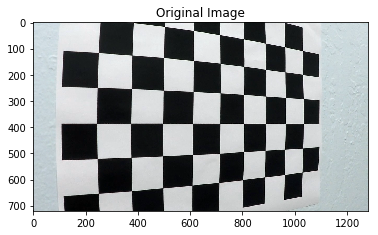

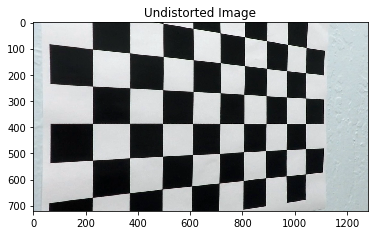

In [3]:
# Distortion correction function
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst, mtx, dist, rvecs, tvecs

# Show an example of original image and undistorted image
undst, mtx, dist, rvecs, tvecs = cal_undistort(image_list[15], objpoints, imgpoints)
plt.figure()
plt.title('Original Image')
plt.imshow(image_list[15])
plt.figure()
plt.title('Undistorted Image')
plt.imshow(undst)
image_shape = image_gray_list[1].shape[::-1]

## Color/Gradient Threshold 

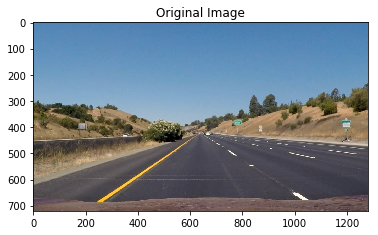

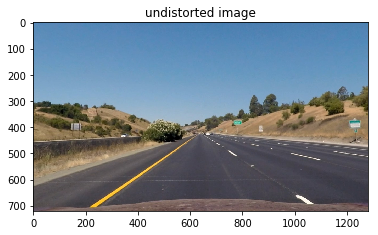

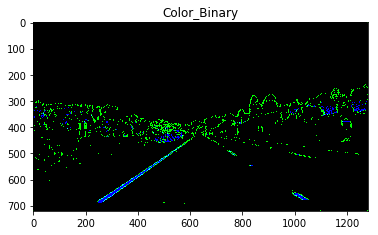

In [4]:
# Read a straight line image
image = cv2.imread('test_images/straight_lines1.jpg')

# Plot the original figure
ori_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(ori_img)
plt.title('Original Image')
# Define threshold on S-channel
s_thresh = (150,255)

# Define threshold on sobel_x channel
sx_thresh = (33,150)
plt.figure()
undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
undistort_image_show = np.copy(undistort_img)
plt.imshow(cv2.cvtColor(undistort_image_show, cv2.COLOR_BGR2RGB))
plt.title('undistorted image')
def thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist):
    img = np.copy(image)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    """ 
    ## Channel Image examples
    h_channel = hsv[:,:,0]
    plt.imshow(l_channel, cmap='gray')
    plt.title('l_channel')
    plt.figure()
    plt.imshow(s_channel, cmap='gray')
    plt.title('s_channel')
    plt.figure()
    plt.imshow(h_channel, cmap='gray')
    plt.title('h_channel')"""
    
    # Sobel_x & Sobel_y
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = 5) # Take the derivative in x
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    return color_binary
color_binary = thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist)
plt.figure()
plt.imshow(color_binary)
plt.title('Color_Binary')

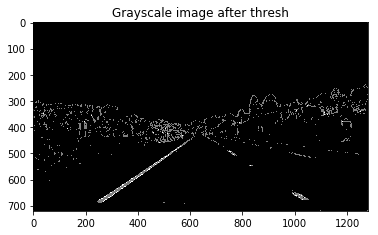

In [5]:
# Show the threshold-image in grayscale
plt.imshow(color_binary[:,:,2]+color_binary[:,:,1], cmap = 'gray')
plt.title('Grayscale image after thresh')

## Perspective Transform

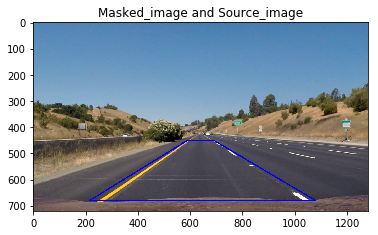

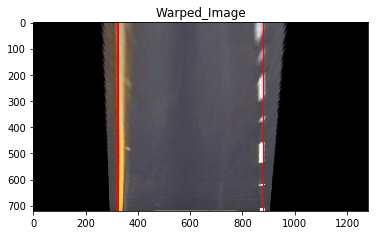

In [6]:
# Define a function perform perspective transform
imshape = image.shape
img_size = (image.shape[1], image.shape[0])
x1 = 215
y1 = 680
x2 = 590
y2 = 450
x3 = 690
y3 = 450
x4 = 1080
y4 = 680
offset = 200

# Draw the mask on the image
def mask(image,x1,x2,x3,x4,y1,y2,y3,y4):
    mask_image = np.copy(image)
    cv2.line(mask_image, (x1,y1), (x2, y2), [255, 0, 0], 3)
    cv2.line(mask_image, (x2, y2), (x3, y3), [255, 0, 0], 3)
    cv2.line(mask_image, (x3, y3), (x4, y4), [255, 0, 0], 3)
    cv2.line(mask_image, (x1, y1),(x4, y4), [255, 0, 0], 3)
    return mask_image

# Filter through the region of interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


mask_draw_image = mask(image,x1,x2,x3,x4,y1,y2,y3,y4)
plt.imshow(cv2.cvtColor(mask_draw_image,cv2.COLOR_BGR2RGB))
plt.title("Masked_image and Source_image")
src = np.float32([(x1,y1), (x2,y2), (x3,y3), (x4,y4)])

vertices = np.array([[(x1,y1), (x2,y2), (x3,y3), (x4,y4)]], dtype=np.int32)
masked_image = region_of_interest(image, vertices)
def pers_trans(image, src, offset, img_size):
        dst = np.float32([[300, img_size[1]],[300, 0], [900, 0], [900, img_size[1]]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(image, M, img_size)
        # Return the resulting image and matrix
        return warped, M

warped_image, M = pers_trans(masked_image, src, offset, img_size)
cv2.line(warped_image, (300+25,img_size[1]), (300+25, 0), [0, 0, 255], 5)
cv2.line(warped_image, (900-20, img_size[1]), (900-20, 0), [0, 0, 255], 5)
plt.figure()
warped_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)
plt.imshow(warped_image)
plt.title('Warped_Image')

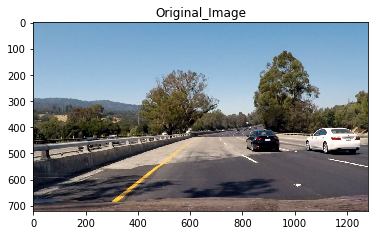

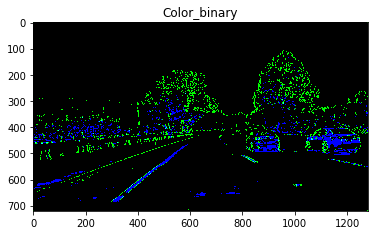

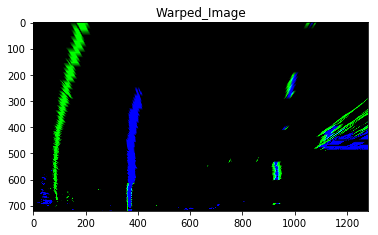

In [9]:
# Show a curved lane image and its warped version
image = cv2.imread('test_images/test4.jpg')
image_copy = np.copy(image)
plt.figure()
plt.imshow(cv2.cvtColor(image_copy,cv2.COLOR_BGR2RGB))
plt.title('Original_Image')
# vertices = np.array([[(x1,y1), (x2,y2), (x3,y3), (x4,y4)]], dtype=np.int32)
# masked_image = region_of_interest(image, vertices)
color_binary = thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist)
plt.figure()
plt.imshow(color_binary)
plt.title('Color_binary')
warped_image, M = pers_trans(color_binary, src, offset, img_size)
plt.figure()
plt.imshow(warped_image)
plt.title('Warped_Image')